In [15]:
root_path = 'santa-workshop-tour-2019/'
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
fpath = root_path + 'family_data.csv'
data = pd.read_csv(fpath, index_col='family_id')

fpath = root_path + 'sample_submission.csv'
submission = pd.read_csv(fpath, index_col='family_id')

In [16]:
family_size_dict = data[['n_people']].to_dict()['n_people']
m,_ = data.shape 

cols = [f'choice_{i}' for i in range(10)]
choice_dict = data[cols].T.to_dict()

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

# from 100 to 1
days = list(range(N_DAYS,0,-1))

In [17]:
def weekday(days):
    weekday = []
    for day in days:
        if day%7==2:
            weekday.append('Monday')
        elif day%7==1:
            weekday.append('Tuesday')
        elif day%7==0:
            weekday.append('Wednesday')
        elif day%7==6:
            weekday.append('Thursday')
        elif day%7==5:
            weekday.append('Friday')
        elif day%7==4:
            weekday.append('Saturday')
        else:
            weekday.append('Sunday')
    return weekday


In [ ]:
weekday_list = [weekday(data[cols].values[i][:].tolist()) for i in range(5000)]
weekday_list = pd.DataFrame(weekday_list,columns = ['weekday_'+cols[i] for i in range(10)])
weekday_list

In [18]:
def difficulty(days):
    dif = []
    for day in days:
        wd = weekday([day])
        if day == 1 or day == 2 or day == 3:
            dif.append(1)
        elif wd[0]=='Monday' or wd[0]=='Tuesday' or wd[0]=='Wednesday' or wd[0]=='Thursday':
            dif.append(0)
        else:
            dif.append(1)
    return dif



In [ ]:
dif_list = [difficulty(data[cols].values[i][:].tolist()) for i in range(5000)]
dif_list = pd.DataFrame(dif_list,columns = ['difficulty_'+cols[i] for i in range(10)])
dif_sum = pd.DataFrame(np.sum(dif_list,axis=1),columns=['dif_sum'])
#data = pd.concat([data,dif_sum],axis=1)
plt.figure(figsize=(16,9))
sns.countplot(dif_sum['dif_sum'])
plt.title("Number of difficult days per family")
print("The mean number of difficult days per family is: {}".format(np.mean(dif_sum['dif_sum'])))
print("Standard deviation of difficult days is: {}".format(np.std(dif_sum['dif_sum'])))

In [19]:
family_size = list(range(2,9))
cost_per_family_size = np.zeros((11,len(family_size)))
def choice_cost(n,choice):
    if choice == 0:
        return 0
    elif choice == 1:
        return 50
    elif choice == 2:
        return 50 + 9 * n
    elif choice == 3:
        return 100 + 9 * n
    elif choice == 4:
        return 200 + 9 * n
    elif choice == 5:
        return 200 + 18 * n
    elif choice == 6:
        return 300 + 18 * n
    elif choice == 7:
        return 300 + 36 * n
    elif choice == 8:
        return 400 + 36 * n
    elif choice == 9:
        return 500 + 36 * n + 199 * n
    else:
        return 500 + 36 * n + 398 * n


In [ ]:
j = 0
for n in family_size:  
    for i in range(11):
        cost_per_family_size[i,j]=choice_cost(n,i)
    j+=1

cost_per_family_size = pd.DataFrame(cost_per_family_size.T,index = [str(x)+'_people' for x in range(2,9)],columns = ['choice_'+str(x) for x in range(11)])
cost_per_family_size['n_people']=list(range(2,9))
cost_per_family_size

In [120]:
sorted_families = []
daily_occupancy={i:0 for i in range(1,101)}
answer = np.zeros((m,3))
for j in range(4):
    for i in range(m):
        if difficulty(data.loc[i][['choice_'+str(j)]])==[0] and i not in sorted_families and daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+data.loc[i][['n_people']][0]<300:
            sorted_families.append(i)
            answer[i,0]=i
            answer[i,1]=data.loc[i][['choice_'+str(j)]]
            answer[i,2]=j
            daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]

In [21]:
def daily_plot(answer):
    def get_daily_occupancy(answer):
        daily_occupancy={i:0 for i in range(0,101)}
        for i in range(m):
            daily_occupancy[int(answer[i,1])]+=data.loc[i]['n_people']
        return daily_occupancy
    daily_occupancy = get_daily_occupancy(answer)
    plt.figure(figsize=(12,7))
    fig = sns.lineplot(x=list(range(1,101)),y=[daily_occupancy[i] for i in range(1,101)])
    ax = plt.axes()
    x = np.linspace(0, 100, 100)
    y= np.linspace(125,125,100)
    ax.plot(x, y,color='green');
    x = np.linspace(0, 100, 100)
    y= np.linspace(300,300,100)
    ax.plot(x, y,color='red')


In [ ]:
daily_plot(answer)

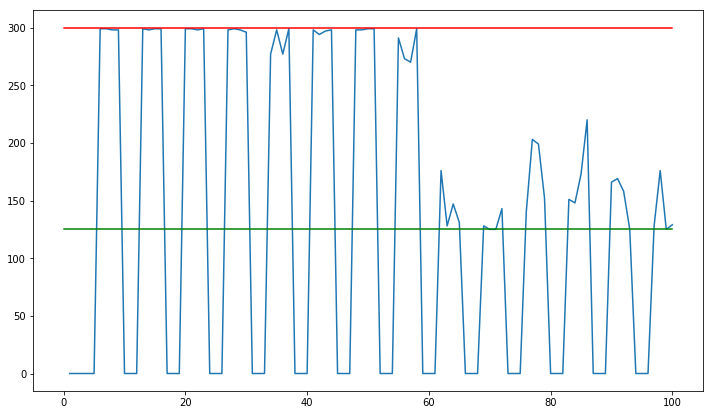

In [122]:
for j in range(4,8):
    for i in range(m):
        if difficulty(data.loc[i][['choice_'+str(j)]])==[0] and i not in sorted_families and daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]<125:
            sorted_families.append(i)
            answer[i,0]=i
            answer[i,1]=data.loc[i][['choice_'+str(j)]]
            answer[i,2]=j
            daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
daily_plot(answer)

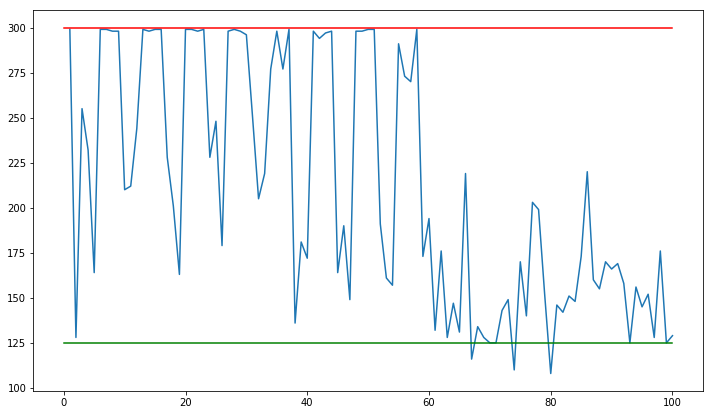

In [123]:
for j in range(4):
    for i in range(m):
        if (difficulty(data.loc[i][['choice_'+str(j)]])==[1] or difficulty(data.loc[i][['choice_'+str(j)]])==[2]) and i not in sorted_families and daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+data.loc[i][['n_people']][0]<300:
            sorted_families.append(i)
            answer[i,0]=i
            answer[i,1]=data.loc[i][['choice_'+str(j)]]
            answer[i,2]=j
            daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
daily_plot(answer)

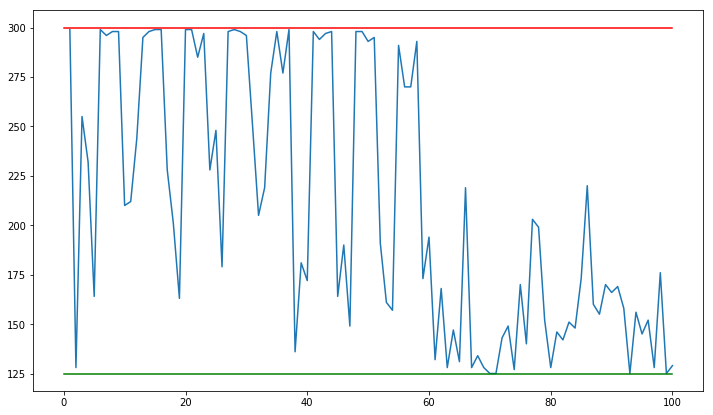

In [124]:
del sorted_families
for k,v in daily_occupancy.items():
    if v<125:
        for j in range(4):
            for i in range(m):
                if daily_occupancy[data.loc[i][['choice_'+str(int(answer[i,2]))]][0]]-data.loc[i][['n_people']][0]>=125 and data.loc[i][['choice_'+str(j)]][0]==k and daily_occupancy[k]<=125:
                    answer[i,0]=i
                    answer[i,1]=data.loc[i][['choice_'+str(j)]]
                    answer[i,2]=j
                    daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
daily_plot(answer)

In [22]:
def accounting(today,yesterday):
    return max(0, (today-125.0) / 400.0 * today**(0.5 + abs(today-yesterday) / 50.0))
acc_matrix = np.zeros((301,301))
for i, x in enumerate(range(1,300+1)):
    for j, y in enumerate(range(1,300+1)):
        acc_matrix[i,j] = np.log10(accounting(x,y))
        


C:\WorkData\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(acc_matrix, 0, 4000))
plt.xlim(125,300)
plt.ylim(125,300)
plt.title('log10(Accounting Cost)')
plt.colorbar()

In [23]:
import numpy as np
import pandas as pd
from numba import njit, prange

family_size = data.n_people.values.astype(np.int8)

penalties = np.asarray([
    [
        0,
        50,
        50 + 9 * n,
        100 + 9 * n,
        200 + 9 * n,
        200 + 18 * n,
        300 + 18 * n,
        300 + 36 * n,
        400 + 36 * n,
        500 + 36 * n + 199 * n,
        500 + 36 * n + 398 * n
    ] for n in range(family_size.max() + 1)
])
family_cost_matrix = np.concatenate(data.n_people.apply(lambda n: np.repeat(penalties[n, 10], 100).reshape(1, 100)))
for fam in data.index:
    for choice_order, day in enumerate(data.loc[fam].drop("n_people")):
        family_cost_matrix[fam, day - 1] = penalties[data.loc[fam, "n_people"], choice_order]
accounting_cost_matrix = np.zeros((500, 500))
for n in range(accounting_cost_matrix.shape[0]):
    for diff in range(accounting_cost_matrix.shape[1]):
        accounting_cost_matrix[n, diff] = max(0, (n - 125.0) / 400.0 * n**(0.5 + diff / 50.0))

In [24]:
@njit(fastmath=True)
def cost_function(prediction, family_size, family_cost_matrix, accounting_cost_matrix):
    N_DAYS = family_cost_matrix.shape[1]
    MAX_OCCUPANCY = 300
    MIN_OCCUPANCY = 125
    penalty = 0
    daily_occupancy = np.zeros(N_DAYS + 1, dtype=np.int16)
    for i, (pred, n) in enumerate(zip(prediction, family_size)):
        daily_occupancy[pred - 1] += n
        penalty += family_cost_matrix[i, pred - 1]

    accounting_cost = 0
    n_low = 0
    n_high = 0
    daily_occupancy[-1] = daily_occupancy[-2]
    for day in range(N_DAYS):
        n_next = daily_occupancy[day + 1]
        n = daily_occupancy[day]
        n_high += (n > MAX_OCCUPANCY) 
        n_low += (n < MIN_OCCUPANCY)
        diff = abs(n - n_next)
        accounting_cost += accounting_cost_matrix[n, diff]

    return np.asarray([penalty, accounting_cost, n_low, n_high])

In [26]:
def get_cost_consolidated(prediction): 
    fc, ac, l, h = cost_function(prediction, family_size, family_cost_matrix, accounting_cost_matrix)
    return (fc + ac) + (l + h) * 10000000


In [ ]:
print(get_cost_consolidated(answer[:,1].astype(np.int8)))

(125, 300)

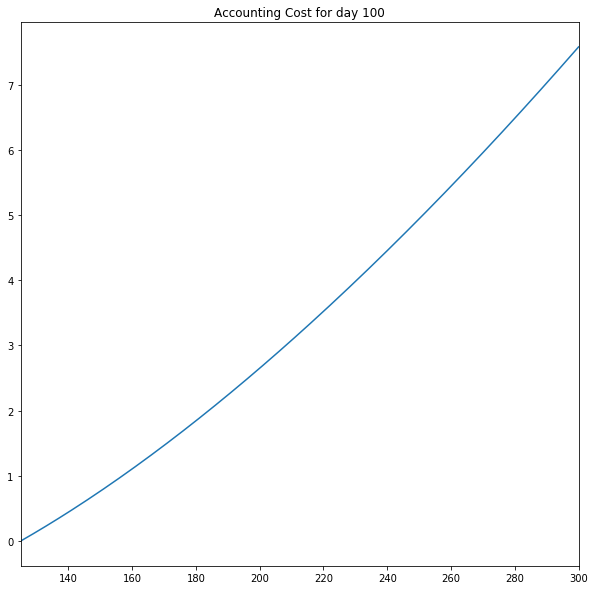

In [129]:
acc_day100 = np.zeros((300,1))
for i, x in enumerate(range(1,300+1)):
    acc_day100[i] = accounting(x,x)
plt.figure(figsize=(10,10))
sns.lineplot(x=[i for i in range(1,301)],y=acc_day100[:,0])
plt.title('Accounting Cost for day 100')
plt.xlim(125,300)

In [130]:
n = 0
for i in range(m):
    n+=data.loc[i][['n_people']][0]
print(str(n)+" total people to visit Santa")

21003 total people to visit Santa


100 0
100 1
100 2
100 3
99 0
99 1
99 2
99 3
98 0
98 1
98 2
98 3
97 0
97 1
97 2
97 3
96 0
96 1
96 2
96 3
95 0
95 1
95 2
95 3
94 0
94 1
94 2
94 3
93 0
93 1
93 2
93 3
92 0
92 1
92 2
92 3
91 0
91 1
91 2
91 3
90 0
90 1
90 2
90 3
89 0
89 1
89 2
89 3
88 0
88 1
88 2
88 3
87 0
87 1
87 2
87 3
86 0
86 1
86 2
86 3
85 0
85 1
85 2
85 3
84 0
84 1
84 2
84 3
83 0
83 1
83 2
83 3
82 0
82 1
82 2
82 3
81 0
81 1
81 2
81 3
80 0
80 1
80 2
80 3
79 0
79 1
79 2
79 3
78 0
78 1
78 2
78 3
77 0
77 1
77 2
77 3
76 0
76 1
76 2
76 3
75 0
75 1
75 2
75 3
74 0
74 1
74 2
74 3
73 0
73 1
73 2
73 3
72 0
72 1
72 2
72 3
71 0
71 1
71 2
71 3
70 0
70 1
70 2
70 3
69 0
69 1
69 2
69 3
68 0
68 1
68 2
68 3
67 0
67 1
67 2
67 3
66 0
66 1
66 2
66 3
65 0
65 1
65 2
65 3
64 0
64 1
64 2
64 3
63 0
63 1
63 2
63 3
62 0
62 1
62 2
62 3
61 0
61 1
61 2
61 3
60 0
60 1
60 2
60 3
59 0
59 1
59 2
59 3
58 0
58 1
58 2
58 3
57 0
57 1
57 2
57 3
56 0
56 1
56 2
56 3
55 0
55 1
55 2
55 3
54 0
54 1
54 2
54 3
53 0
53 1
53 2
53 3
52 0
52 1
52 2
52 3
51 0
51 1
51 2
5

C:\WorkData\anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


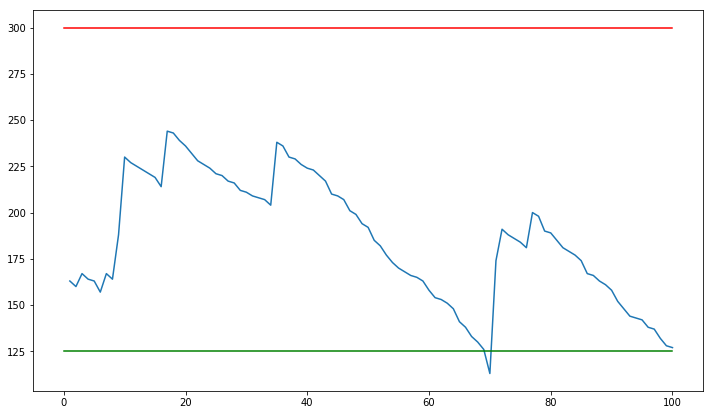

In [132]:
sorted_families = {i:0 for i in range(m)}
daily_occupancy={i:0 for i in range(1,101)}
answer = np.zeros((m,2))
prev_day = 125
diff = 1
factor = 7
for day in days:
    for choice in range(4):
        print(day, choice)
        for i in range(m):
            if data.loc[i][['choice_'+str(choice)]][0]==day and sorted_families[i]==0:
                if daily_occupancy[day]+data.loc[i][['n_people']][0]<=300:
                    if daily_occupancy[day]-prev_day<diff and daily_occupancy[day]-prev_day<diff*factor:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=day
                        daily_occupancy[day]+=data.loc[i][['n_people']][0]
                    elif daily_occupancy[day]<125:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=day
                        daily_occupancy[day]+=data.loc[i][['n_people']][0]
    prev_day = daily_occupancy[day]
daily_plot(answer)

4433 0
4433 1
4433 2
4433 3
4433 4
4433 5
4433 6
4433 7
4433 8
1# iteration -> 4464 families sorted with a combined cost of 1355391.5029881669
4464 0
4464 1
4464 2
4464 3
4464 4
4464 5
4464 6
4464 7
4464 8
2# iteration -> 4599 families sorted with a combined cost of 1062949.5628151936
4599 0
4599 1
4599 2
4599 3
4599 4
4599 5
4599 6
4599 7
4599 8
3# iteration -> 4712 families sorted with a combined cost of 818252.1514330058
4712 0
4712 1
4712 2
4712 3
4712 4
4712 5
4712 6
4712 7
4712 8
4# iteration -> 4811 families sorted with a combined cost of 606774.8686559763
4811 0
4811 1
4811 2
4811 3
4811 4
4811 5
4811 6
4811 7
4811 8
5# iteration -> 4894 families sorted with a combined cost of 441512.50115352054
4894 0
4894 1
4894 2
4894 3
4894 4
4894 5
4894 6
4894 7
4894 8
6# iteration -> 4965 families sorted with a combined cost of 321620.89846794214
4965 0
4965 1
4965 2
4965 3
4965 4
4965 5
4965 6
4965 7
4965 8
7# iteration -> 4996 families sorted with a combined cost of 252192.99033675506
4

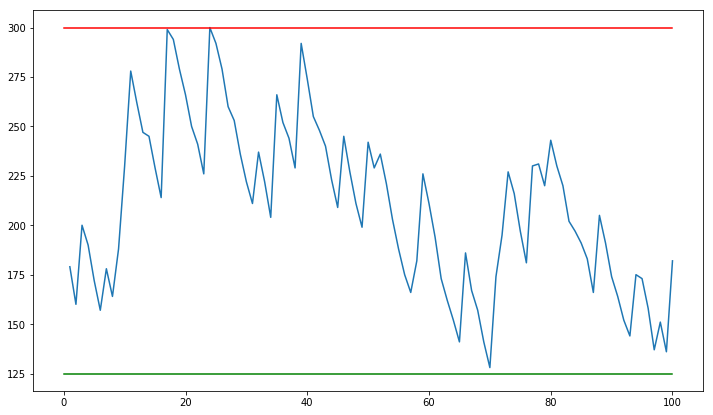

In [134]:
diff_normalizer = 1
diff = 2
count=sum([sorted_families[i]==1 for i in range(m)])
while count<m:
    daily_occupancy[101]=daily_occupancy[100]
    for j in range(9):
        print(count, j)
        for i in range(m):
            daily_occupancy[101]=daily_occupancy[100]
            if sorted_families[i]==0:
                if daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+data.loc[i][['n_people']][0]<=300:
                    if abs(daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]-daily_occupancy[data.loc[i][['choice_'+str(j)]][0]+1])<diff_normalizer*diff:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=data.loc[i][['choice_'+str(j)]]
                        daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
                    elif daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]<125:
                        sorted_families[i]=1
                        answer[i,0]=i
                        answer[i,1]=data.loc[i][['choice_'+str(j)]]
                        daily_occupancy[data.loc[i][['choice_'+str(j)]][0]]+=data.loc[i][['n_people']][0]
    count=sum([sorted_families[i]==1 for i in range(m)])
    print("{}# iteration -> {} families sorted with a combined cost of {}".format(diff_normalizer,count,get_cost_consolidated(answer[:,1].astype(np.int8))))
    diff_normalizer+=1
daily_plot(answer)

In [174]:
import tqdm
def optimize(answer,n_iter=100,verbose=5,print_ = False,rd_seed=23):
    import random
    try:
        new_answer=answer[:,1].copy()
        best_score = get_cost_consolidated(new_answer[:].astype(np.int8))
    except IndexError:
        new_answer=answer.copy()
        best_score = get_cost_consolidated(new_answer[:].astype(np.int8))
    if print_:
        print('Start score: {}'.format(best_score))
    start_score = best_score
    random.seed(rd_seed)
    family_list = list(range(m))
    for n in tqdm.tqdm_notebook(range(n_iter)):
        random.shuffle(days)
        random.shuffle(family_list)
        for day in days:
            for i in family_list:
                aux = new_answer[i]
                new_answer[i]=day
                new_score = get_cost_consolidated(new_answer[:].astype(np.int8))
                if new_score<=best_score:
                    try:
                        answer[i,1]=day
                    except:
                        answer[i]=day
                    best_score = new_score
                else:
                    new_answer[i]=aux
        if not best_score == start_score:
            start_score = best_score
        else:
            print("{}# early stopping best score: {}".format(n+1,best_score))
            break
        if (n+1)%verbose==0 and print_:
            print("{}# best score: {}".format(n+1,best_score))
    return answer


In [192]:
def find_seed(answer):
    start_answer = answer.copy()
    best_score = get_cost_consolidated(answer[:,1].astype(np.int8))
    best = 0
    for i in range(1000):
        new_answer = optimize(start_answer[:,1].copy(),n_iter=2000,verbose=5,print_=False,rd_seed = i)
        new_score = get_cost_consolidated(new_answer[:].astype(np.int8))
        if new_score<best_score:
            best_score = new_score
            best = i
            print(best)
    return best

In [193]:
import pandas as pd
answer_new = np.array(pd.read_csv('submission.csv'), float)

In [194]:
answer = answer_new


In [195]:
answer = optimize(answer_new,n_iter=200,verbose=5,print_=True,rd_seed=23)

Start score: 72750.76061053449


AttributeError: 'function' object has no attribute 'tqdm_notebook'

72750.76061053449

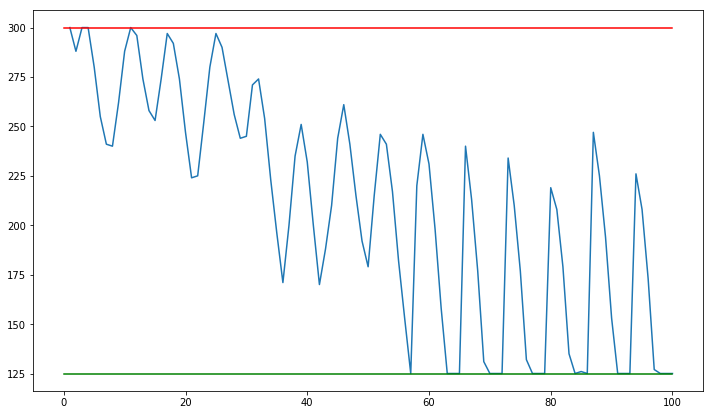

In [196]:
daily_plot(answer)
get_cost_consolidated(answer[:,1].astype(np.int8))

In [198]:
from itertools import product
from tqdm import tqdm_notebook as tqdm
choice_matrix = data.loc[:, 'choice_0': 'choice_9'].values
def stochastic_product_search(top_k, fam_size, original, choice_matrix, 
                              disable_tqdm=False, verbose=10000,
                              n_iter=500, random_state=2000):
    """
    original (np.array): The original day assignments.
    
    At every iterations, randomly sample fam_size families. Then, given their top_k
    choices, compute the Cartesian product of the families' choices, and compute the
    score for each of those top_k^fam_size products.
    """
    
    best = original.copy()
    best_score = get_cost_consolidated(best)
    
    np.random.seed(random_state)

    for i in tqdm(range(n_iter), disable=disable_tqdm):
        fam_indices = np.random.choice(range(choice_matrix.shape[0]), size=fam_size)
        changes = np.array(list(product(*choice_matrix[fam_indices, :top_k].tolist())))

        for change in changes:
            new = best.copy()
            new[fam_indices] = change

            new_score = get_cost_consolidated(new)

            if new_score < best_score:
                best_score = new_score
                best = new
        
        if new_score < best_score:
            best_score = new_score
            best = new
    
        if verbose and i % verbose == 0:
            print(f"Iteration #{i}: Best score is {best_score:.2f}")
    
    print(f"Final best score is {best_score:.2f}")
    return best

final = stochastic_product_search(
        top_k=4,
        fam_size=3, 
        original=answer[:,1].astype(np.int8),
        choice_matrix = choice_matrix,
        disable_tqdm = False,
        n_iter=1000000,
        verbose=10000,
        )

prediction = pd.Series(final.astype(np.int8), name="assigned_day")
prediction.index.name = "family_id"
prediction.to_csv("submission.csv", index=True, header=True)

Iteration #0: Best score is 72750.76
Iteration #10000: Best score is 72750.76
Iteration #20000: Best score is 72750.76
Iteration #30000: Best score is 72750.76
Iteration #40000: Best score is 72750.76
Iteration #50000: Best score is 72750.76
Iteration #60000: Best score is 72750.76
Iteration #70000: Best score is 72750.76
Iteration #80000: Best score is 72750.76
Iteration #90000: Best score is 72750.76
Iteration #100000: Best score is 72750.76
Iteration #110000: Best score is 72750.76
Iteration #120000: Best score is 72750.76
Iteration #130000: Best score is 72750.76
Iteration #140000: Best score is 72750.76
Iteration #150000: Best score is 72750.76
Iteration #160000: Best score is 72750.76
Iteration #170000: Best score is 72750.76
Iteration #180000: Best score is 72750.76
Iteration #190000: Best score is 72750.76
Iteration #200000: Best score is 72750.76
Iteration #210000: Best score is 72750.76
Iteration #220000: Best score is 72750.76
Iteration #230000: Best score is 72750.76
Iterat

Iteration #0: Best score is 72750.76
Iteration #1000: Best score is 72750.76
Iteration #2000: Best score is 72750.76
Iteration #3000: Best score is 72750.76
Iteration #4000: Best score is 72750.76
Iteration #5000: Best score is 72750.76
Iteration #6000: Best score is 72750.76
Iteration #7000: Best score is 72750.76
Iteration #8000: Best score is 72750.76
Iteration #9000: Best score is 72750.76
Iteration #10000: Best score is 72750.76
Iteration #11000: Best score is 72750.76
Iteration #12000: Best score is 72750.76
Iteration #13000: Best score is 72750.76
Iteration #14000: Best score is 72750.76
Iteration #15000: Best score is 72750.76
Iteration #16000: Best score is 72750.76
Iteration #17000: Best score is 72750.76
Iteration #18000: Best score is 72750.76
Iteration #19000: Best score is 72750.76
Iteration #20000: Best score is 72750.76
Iteration #21000: Best score is 72750.76
Iteration #22000: Best score is 72750.76
Iteration #23000: Best score is 72750.76
Iteration #24000: Best score 

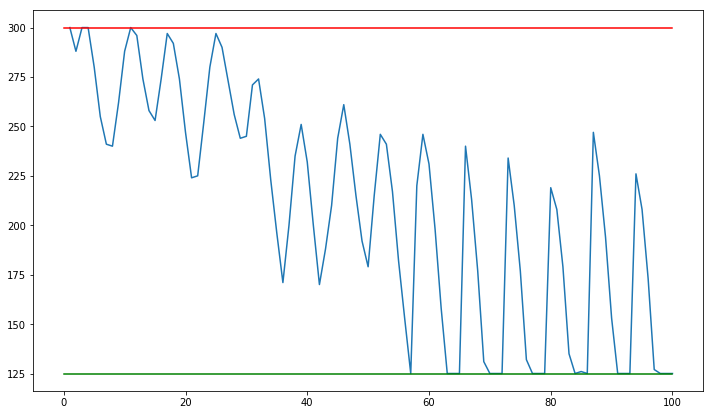

In [190]:
aux = np.zeros((m,2))
aux[:,1]=final
final = stochastic_product_search(
        top_k=4,
        fam_size=5, 
        original=final.astype(np.int8),
        choice_matrix = choice_matrix,
        disable_tqdm = False,
        n_iter=50000,
        verbose=1000,
        )
daily_plot(aux)

prediction = pd.Series(final.astype(np.int8), name="assigned_day")
prediction.index.name = "family_id"
prediction.to_csv("submission.csv", index=True, header=True)

Iteration #0: Best score is 72750.76
Iteration #500: Best score is 72750.76
Iteration #1000: Best score is 72750.76
Iteration #1500: Best score is 72750.76
Iteration #2000: Best score is 72750.76
Iteration #2500: Best score is 72750.76
Iteration #3000: Best score is 72750.76
Iteration #3500: Best score is 72750.76
Iteration #4000: Best score is 72750.76
Iteration #4500: Best score is 72750.76
Iteration #5000: Best score is 72750.76
Iteration #5500: Best score is 72750.76
Iteration #6000: Best score is 72750.76
Iteration #6500: Best score is 72750.76
Iteration #7000: Best score is 72750.76
Iteration #7500: Best score is 72750.76
Iteration #8000: Best score is 72750.76
Iteration #8500: Best score is 72750.76
Iteration #9000: Best score is 72750.76
Iteration #9500: Best score is 72750.76
Iteration #10000: Best score is 72750.76
Iteration #10500: Best score is 72750.76
Iteration #11000: Best score is 72750.76
Iteration #11500: Best score is 72750.76
Iteration #12000: Best score is 72750.76

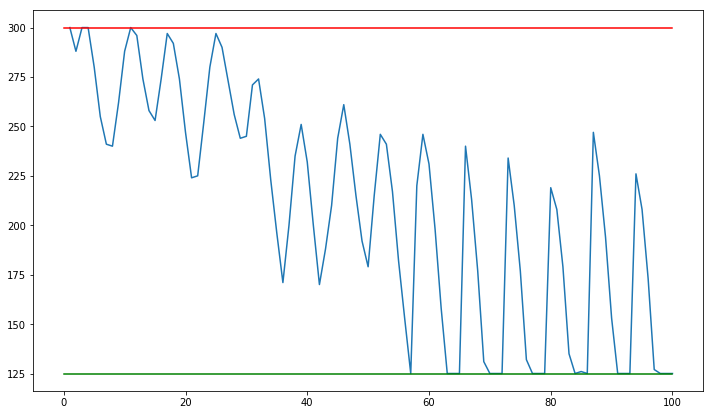

In [191]:
final = stochastic_product_search(
        top_k=3,
        fam_size=8, 
        original=final.astype(np.int8),
        choice_matrix = choice_matrix,
        disable_tqdm = False,
        n_iter=40000,
        verbose=500,
        )
aux = np.zeros((m,2))
aux[:,1]=final
daily_plot(aux)

prediction = pd.Series(final.astype(np.int8), name="assigned_day")
prediction.index.name = "family_id"
prediction.to_csv("submission.csv", index=True, header=True)

In [64]:
prediction = pd.Series(final.astype(np.int8), name="assigned_day")
prediction.index.name = "family_id"
prediction.to_csv("submission.csv", index=True, header=True)